In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

img_folder = '/home/wf1497c/ML/UCSD/ECE 269/hw4/upload_dataset'
images = load_images_from_folder(img_folder)

In [3]:
data_neutral = []
data_smile = []
M = len(images)
original_size = images[0].shape

for i in range(int(M / 2)):
    data_neutral.append(images[2 * i].flatten())

for i in range(int(M / 2)):
    data_smile.append(images[2 * i + 1].flatten())

In [4]:
def random_images(m = 100, smiling = True):
    a = [i for i in range(171)]
    random_ind = np.random.choice(int(M/2), m, replace=False)
    random_ind_test = list(set(a).difference(set(random_ind)))
    im = []
    im_test = []
    for i in random_ind:
        if smiling:
            im.append(data_smile[i])
        else:
            im.append(data_neutral[i])

    for j in random_ind_test:
        if smiling:
            im_test.append(data_smile[j])
        else:
            im_test.append(data_neutral[j])
    return im, im_test

In [5]:
X_neutral, X_neutral_test = random_images(100, smiling=False)
X_smile, X_smile_test = random_images(100, smiling=True)

Text(0.5, 1.0, 'Smiling Facial Expression')

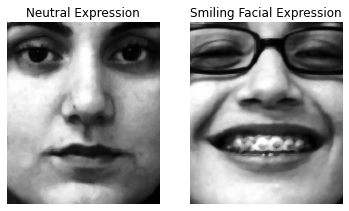

In [6]:
plt.subplot(1,2,1)
plt.imshow(X_neutral[0].reshape(original_size), cmap = 'gray')
plt.axis('off')
plt.title('Neutral Expression')
plt.subplot(1,2,2)
plt.imshow(X_smile[0].reshape(original_size), cmap = 'gray')
plt.axis('off')
plt.title('Smiling Facial Expression')

In [7]:
mean_neutral = np.mean(X_neutral, axis=0)
mean_smile = np.mean(X_smile, axis=0)
X_neutral_nor = X_neutral - mean_neutral 
X_smile_nor = X_smile - mean_smile

In [8]:
ATA_neutral = np.dot(X_neutral_nor,X_neutral_nor.T)
ATA_smile = np.dot(X_smile_nor,X_smile_nor.T)
evalue_neutral, evector_neutral = np.linalg.eig(ATA_neutral)
evalue_smile, evector_smile = np.linalg.eig(ATA_smile)


In [9]:
idx = np.argsort(-evalue_neutral)
eigenvalue = np.sqrt(evalue_neutral[idx])
eigenvector = evector_neutral[:,idx]
evalue_neutral = evalue_neutral[idx]
evector_neutral = evector_neutral[:,idx]

idx = np.argsort(-evalue_smile)
eigenvalue = np.sqrt(evalue_smile[idx])
eigenvector = evector_smile[:,idx]
evalue_smile = evalue_smile[idx]
evector_smile = evector_smile[:,idx]

Eigenvalues in Neutral Expression

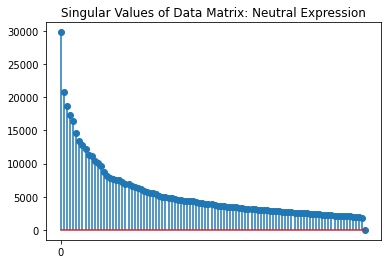

In [10]:
plt.title('Singular Values of Data Matrix: Neutral Expression')
plt.stem(np.sqrt(evalue_neutral[:]),use_line_collection=True)
my_x_ticks = np.arange(0, 10, 10)
plt.xticks(my_x_ticks)
plt.show()

Eigenvalues in Smiling Expression

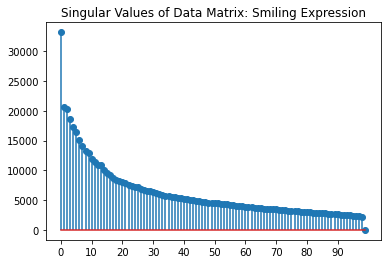

In [11]:
plt.title('Singular Values of Data Matrix: Smiling Expression')
plt.stem(np.sqrt(evalue_smile[:]),use_line_collection=True)
my_x_ticks = np.arange(0, 100, 10)
plt.xticks(my_x_ticks)
plt.show()


According to paper, "the associated eigenvalues allow us to rank the eigenvectors according to their usefulness in charaterizing the variation among the images". The order of eigenvalues indicates which eigenvector encodes more information about the variantion of the training images. The eigenvalues of matrix C = AA.T, which represents covariace matrix of images, is showb as these two figures. I select 50 principle components with largeset eigenvalues

Eigenfaces Calculation

In [12]:
eigenface_neutral = np.dot(X_neutral_nor.T,evector_neutral)
eigenface_smile = np.dot(X_smile_nor.T,evector_smile)

eigenface_neutral = eigenface_neutral / np.linalg.norm(eigenface_neutral , axis = 0)
eigenface_smile = eigenface_smile / np.linalg.norm(eigenface_smile , axis = 0)

Eigenfaces in Neutral Expression

Text(0.5, 0.98, 'First M Eigenfaces in Neutral Expression(M = 10)')

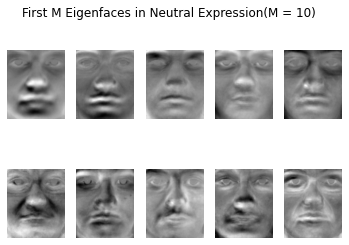

In [13]:
fig, axs = plt.subplots(2,5)
for i in np.arange(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(np.array(eigenface_neutral[:,i].reshape(original_size)), cmap = 'gray')
    plt.axis('off')
fig.suptitle("First M Eigenfaces in Neutral Expression(M = 10)")

Eigenfaces in Smiling Expression

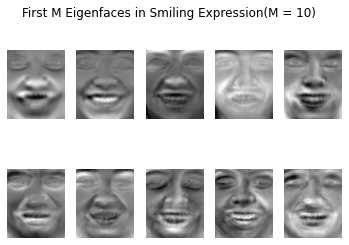

In [14]:
fig, axs = plt.subplots(2,5)
fig.suptitle("First M Eigenfaces in Smiling Expression(M = 10)")
for i in np.arange(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(np.array(eigenface_smile[:,i].reshape(original_size)), cmap = 'gray')
    plt.axis('off')


As we can see in the above ten eigenfaces, different picture shows different information. Mean face contain the basic information of our 171 pictures in the dataset for each class. Eigenfaces reflect the differences between all pictures. So we can use eigenfaces to reconstruct faces based on meanface. Hence, M is much less than N^2. We achieve to use just M eigenfaces to reconstruct in which M eigenfaces are the PCs.

Reconstruction Using Eigenfaces

In [15]:
img_sample_neutral = X_neutral_nor[0]
img_sample_smile = X_smile_nor[0]

In [16]:
def Reconstruction(img, eigenface_num, eigenface):
    wk = eigenface[:,0:eigenface_num].T.dot(img)
    img_reconstruct = eigenface[:,0:eigenface_num].dot(wk)
    img_reconstruct
    return MSE(img,img_reconstruct), img_reconstruct

def MSE(x,y):
    """ This function is for compute the MSE """
    mse = ((x - y) ** 2).mean(axis = 0)
    return mse

In [17]:
_, img_sample_neutral_re = Reconstruction(img_sample_neutral, 50, eigenface_neutral)
_, img_sample_smile_re = Reconstruction(img_sample_smile, 50, eigenface_smile)

(-0.5, 161.5, 192.5, -0.5)

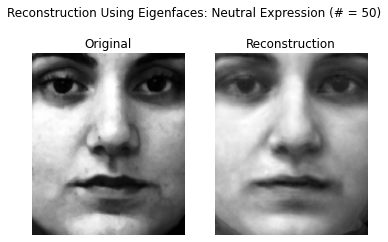

In [18]:
fig, axs = plt.subplots(1,2)
fig.suptitle("Reconstruction Using Eigenfaces: Neutral Expression (# = 50)")

ax = plt.subplot(1,2,1)
ax.title.set_text('Original')
plt.imshow((img_sample_neutral + mean_neutral).reshape(original_size),cmap = 'gray')
plt.axis('off')

ax = plt.subplot(1,2,2)
ax.title.set_text('Reconstruction')
plt.imshow((img_sample_neutral_re + mean_neutral).reshape(original_size),cmap = 'gray')
plt.axis('off')

(-0.5, 161.5, 192.5, -0.5)

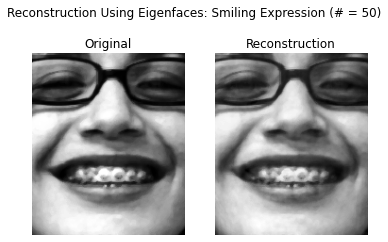

In [19]:
fig, axs = plt.subplots(1,2)
fig.suptitle("Reconstruction Using Eigenfaces: Smiling Expression (# = 50)")

ax = plt.subplot(1,2,1)
ax.title.set_text('Original')
plt.imshow((img_sample_smile + mean_smile).reshape(original_size),cmap = 'gray')
plt.axis('off')

ax = plt.subplot(1,2,2)
ax.title.set_text('Reconstruction')
plt.imshow((img_sample_smile_re + mean_smile).reshape(original_size),cmap = 'gray')
plt.axis('off')

Text(0.5, 0, 'Number of PC')

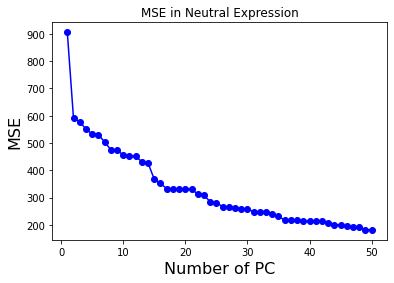

In [20]:
mse_list_neutral = []
for num_PC in range(1,51):
    mse, _ = Reconstruction(img_sample_neutral, num_PC, eigenface_neutral)
    mse_list_neutral.append(mse)

plt.figure()
plt.title('MSE in Neutral Expression')
plt.plot(range(1,51), mse_list_neutral, 'bo-')
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)

Text(0.5, 0, 'Number of PC')

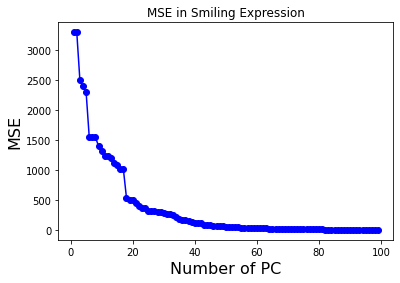

In [21]:
mse_list_smile = []
for num_PC in range(1,100):
    mse, _ = Reconstruction(img_sample_smile, num_PC, eigenface_smile)
    mse_list_smile.append(mse)

plt.figure()
plt.title('MSE in Smiling Expression')
plt.plot(range(1,100), mse_list_smile, 'bo-')
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)

Principle component analysis involves finding a lower dimensional subspace the the training data belongs to. Also, since the reconstructed image belongs to "face space", such reconstruction can be interpreted as linear combination of eigenfaces. The result of MSE is not suprising, with more principle componenents get involve in this linear combination, less error would occur. 

Experiment 4: Reconstrcut one image outside training dataset

In [22]:
img_sample_neutral = X_neutral_test[0].flatten() - mean_neutral
img_sample_smile = X_smile_test[0].flatten() - mean_smile

In [23]:
_, img_sample_neutral_re = Reconstruction(img_sample_neutral, 50, eigenface_neutral)
_, img_sample_smile_re = Reconstruction(img_sample_smile, 50, eigenface_smile)

(-0.5, 161.5, 192.5, -0.5)

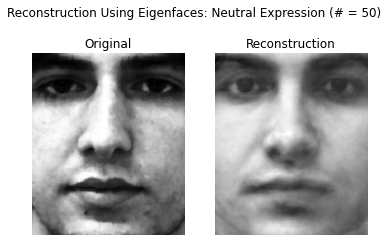

In [24]:
fig, axs = plt.subplots(1,2)
fig.suptitle("Reconstruction Using Eigenfaces: Neutral Expression (# = 50)")

ax = plt.subplot(1,2,1)
ax.title.set_text('Original')
plt.imshow((img_sample_neutral + mean_neutral).reshape(original_size),cmap = 'gray')
plt.axis('off')

ax = plt.subplot(1,2,2)
ax.title.set_text('Reconstruction')
plt.imshow((img_sample_neutral_re + mean_neutral).reshape(original_size),cmap = 'gray')
plt.axis('off')

(-0.5, 161.5, 192.5, -0.5)

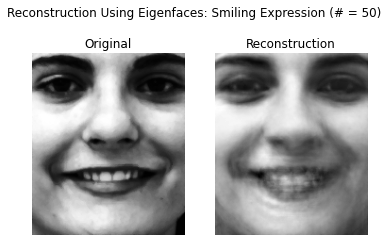

In [25]:
fig, axs = plt.subplots(1,2)
fig.suptitle("Reconstruction Using Eigenfaces: Smiling Expression (# = 50)")

ax = plt.subplot(1,2,1)
ax.title.set_text('Original')
plt.imshow((img_sample_smile + mean_smile).reshape(original_size),cmap = 'gray')
plt.axis('off')

ax = plt.subplot(1,2,2)
ax.title.set_text('Reconstruction')
plt.imshow((img_sample_smile_re + mean_smile).reshape(original_size),cmap = 'gray')
plt.axis('off')

The main contour in face, such as eyes, nose, and wrinkle can be reconstructed with 50 principle componenets, but teeth part is more difficult in smiling expression. The mouth part is an undefined blur that looks unreal. This result is reasonable since teeth part would not belong to neutral face space. Because none of training images have teeth showing, such part cannot be accurately reconstructed. 

Text(0.5, 0, 'Number of PC')

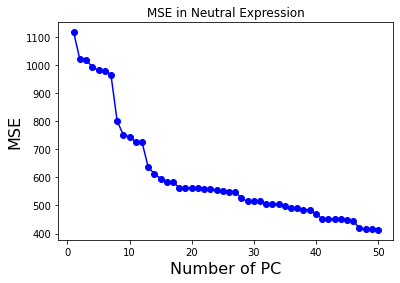

In [26]:
mse_list_neutral = []
for num_PC in range(1,51):
    mse, _ = Reconstruction(img_sample_neutral, num_PC, eigenface_neutral)
    mse_list_neutral.append(mse)

plt.figure()
plt.title('MSE in Neutral Expression')
plt.plot(range(1,51), mse_list_neutral, 'bo-')
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)

Text(0.5, 0, 'Number of PC')

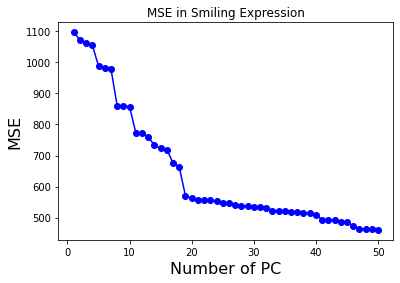

In [27]:
mse_list_smile = []
for num_PC in range(1,51):
    mse, _ = Reconstruction(img_sample_smile, num_PC, eigenface_smile)
    mse_list_smile.append(mse)

plt.figure()
plt.title('MSE in Smiling Expression')
plt.plot(range(1,51), mse_list_smile, 'bo-')
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Number of PC", fontsize=16)

Facial Expression Classification

In [28]:
X_neutral_test = X_neutral_test[:30] - mean_neutral
X_smile_test = X_smile_test[:30] - mean_neutral
X_test = np.concatenate((X_neutral_test, X_smile_test))

In [29]:
def classifier(img, num_PCs):
    mse_smile, _ = Reconstruction(img, num_PCs, eigenface_smile)
    mse_neutral, _ = Reconstruction(img, num_PCs, eigenface_neutral)
    res = 0
    if mse_smile < mse_neutral:
        res = 1 # label = 1 means smiling expression

    return res

test_num = len(X_neutral_test)
prediction_neutral = np.zeros(test_num, dtype = int)
prediction_smile = np.zeros(test_num, dtype = int)
for i in range(test_num):
    prediction_neutral[i] = classifier(X_neutral_test[i], 50)
    prediction_smile[i] = classifier(X_smile_test[i], 50)

acc_neutral = 1 - np.sum(prediction_neutral) / test_num
acc_smile = np.sum(prediction_smile) / test_num

print('Classification accuracy in neutral expression:', acc_neutral * 100, '%')
print('Classification accuracy in smiling expression:', acc_smile * 100, '%')

Classification accuracy in neutral expression: 93.33333333333333 %
Classification accuracy in smiling expression: 83.33333333333334 %


Mistakenly Label Images

(-0.5, 161.5, 192.5, -0.5)

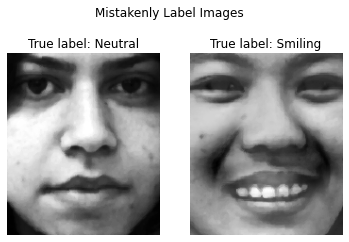

In [30]:
X_neutral_false = X_neutral_test[np.argmax(prediction_neutral)]
X_smile_false = X_smile_test[np.argmin(prediction_smile)]

fig, axs = plt.subplots(1,2)
fig.suptitle("Mistakenly Label Images")

ax = plt.subplot(1,2,1)
ax.title.set_text('True label: Neutral')
plt.imshow((X_neutral_false + mean_neutral).reshape(original_size),cmap = 'gray')
plt.axis('off')

ax = plt.subplot(1,2,2)
ax.title.set_text('True label: Smiling')
plt.imshow((X_smile_false + mean_smile).reshape(original_size),cmap = 'gray')
plt.axis('off')